回帰

## 必要なライブラリのimport

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import warnings
import time
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [3]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
%cd "../content/drive/MyDrive/riku_clv&churn&ltv/data"

/content/drive/MyDrive/riku_clv&churn&ltv/data


In [5]:
# データの読み込み
path_train_prepro = 'train_processed_clv&churn&ltv.csv'
train = pd.read_csv(path_train_prepro)

# 目的変数と説明変数の作成
target = train['target']
#del train['target']

## 特徴選択の実施

In [6]:
# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id','feature_1','feature_2', 'feature_3', 'target']]
categorical_feats = ['feature_1','feature_2', 'feature_3',]
# 'hist_merchant_category_mode','hist_city_mode','hist_state_mode','hist_category_1_mod','hist_category_2_mod','hist_category_3_mod',
# 'total_merchant_category_mode','total_city_mode','total_state_mode','total_category_1_mod','total_category_2_mod','total_category_3_mod',
# 'new_merchant_category_mode','new_city_mode','new_state_mode','new_category_1_mod','new_category_2_mod','new_category_3_mod']

In [7]:
from lightgbm import LGBMRegressor
# lightgbmのパラメータ
param = {'num_leaves': 111,
         'min_data_in_leaf': 149,
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

# インスタンス
rfe = RFE(LGBMRegressor(**param),  n_features_to_select = int(len(features) * 0.95))
# 特徴量選定（変数選択）の実施
X_rfe = rfe.fit(train[features],target)
X_selected = train[features].columns[X_rfe.support_]
# 選択した特徴量
print(X_selected)

Index(['first_active_month', 'elapsed_time', 'quarter', 'days_feature1',
       'days_feature2', 'days_feature3', 'days_feature1_ratio',
       'days_feature2_ratio', 'days_feature3_ratio', 'feature_sum',
       ...
       'total_frequency_rfm', 'total_recency_rfm', 'total_T_rfm',
       'total_monetary_value', 'total_predicted_purchases',
       'total_predicted_monetary_value', 'total_clv', 'new_LTV', 'hist_LTV',
       'total_LTV'],
      dtype='object', length=314)


In [8]:
X_selected = list(X_selected)
X_selected.extend(categorical_feats)

In [9]:
# lightgbmのパラメータ
param = {'num_leaves': 111,
         'min_data_in_leaf': 149,
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [10]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=26)
oof = np.zeros(len(train))
predictions = np.zeros(len(target))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][X_selected],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][X_selected],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(
                    params = param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)],
                    )

    #clf = lgb.train(param, trn_data)

    oof[val_idx] = clf.predict(train.iloc[val_idx][X_selected], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X_selected
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    os.makedirs('../src/models/rfe_lgbm095_nan/', exist_ok=True)
    with open(f'../src/models/rfe_lgbm095_nan/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.70954
[200]	valid_0's rmse: 3.66109
[300]	valid_0's rmse: 3.63807
[400]	valid_0's rmse: 3.62564
[500]	valid_0's rmse: 3.61908
[600]	valid_0's rmse: 3.61492
[700]	valid_0's rmse: 3.61252
[800]	valid_0's rmse: 3.61054
[900]	valid_0's rmse: 3.60899
[1000]	valid_0's rmse: 3.60807
[1100]	valid_0's rmse: 3.60741
[1200]	valid_0's rmse: 3.6066
[1300]	valid_0's rmse: 3.60617
[1400]	valid_0's rmse: 3.60592
[1500]	valid_0's rmse: 3.60557
[1600]	valid_0's rmse: 3.60539
[1700]	valid_0's rmse: 3.60513
[1800]	valid_0's rmse: 3.6053
[1900]	valid_0's rmse: 3.60536
Early stopping, best iteration is:
[1700]	valid_0's rmse: 3.60513
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.74337
[200]	valid_0's rmse: 3.69352
[300]	valid_0's rmse: 3.66965
[400]	valid_0's rmse: 3.65691
[500]	valid_0's rmse: 3.64966
[600]	valid_0's rmse: 3.64582
[700]	valid_0's rmse: 3.64296
[800

In [11]:
# 使用変数の保存
with open('../src/models/rfe_lgbm095_nan/feature.pkl', 'wb') as f:
    pickle.dump(X_selected, f)

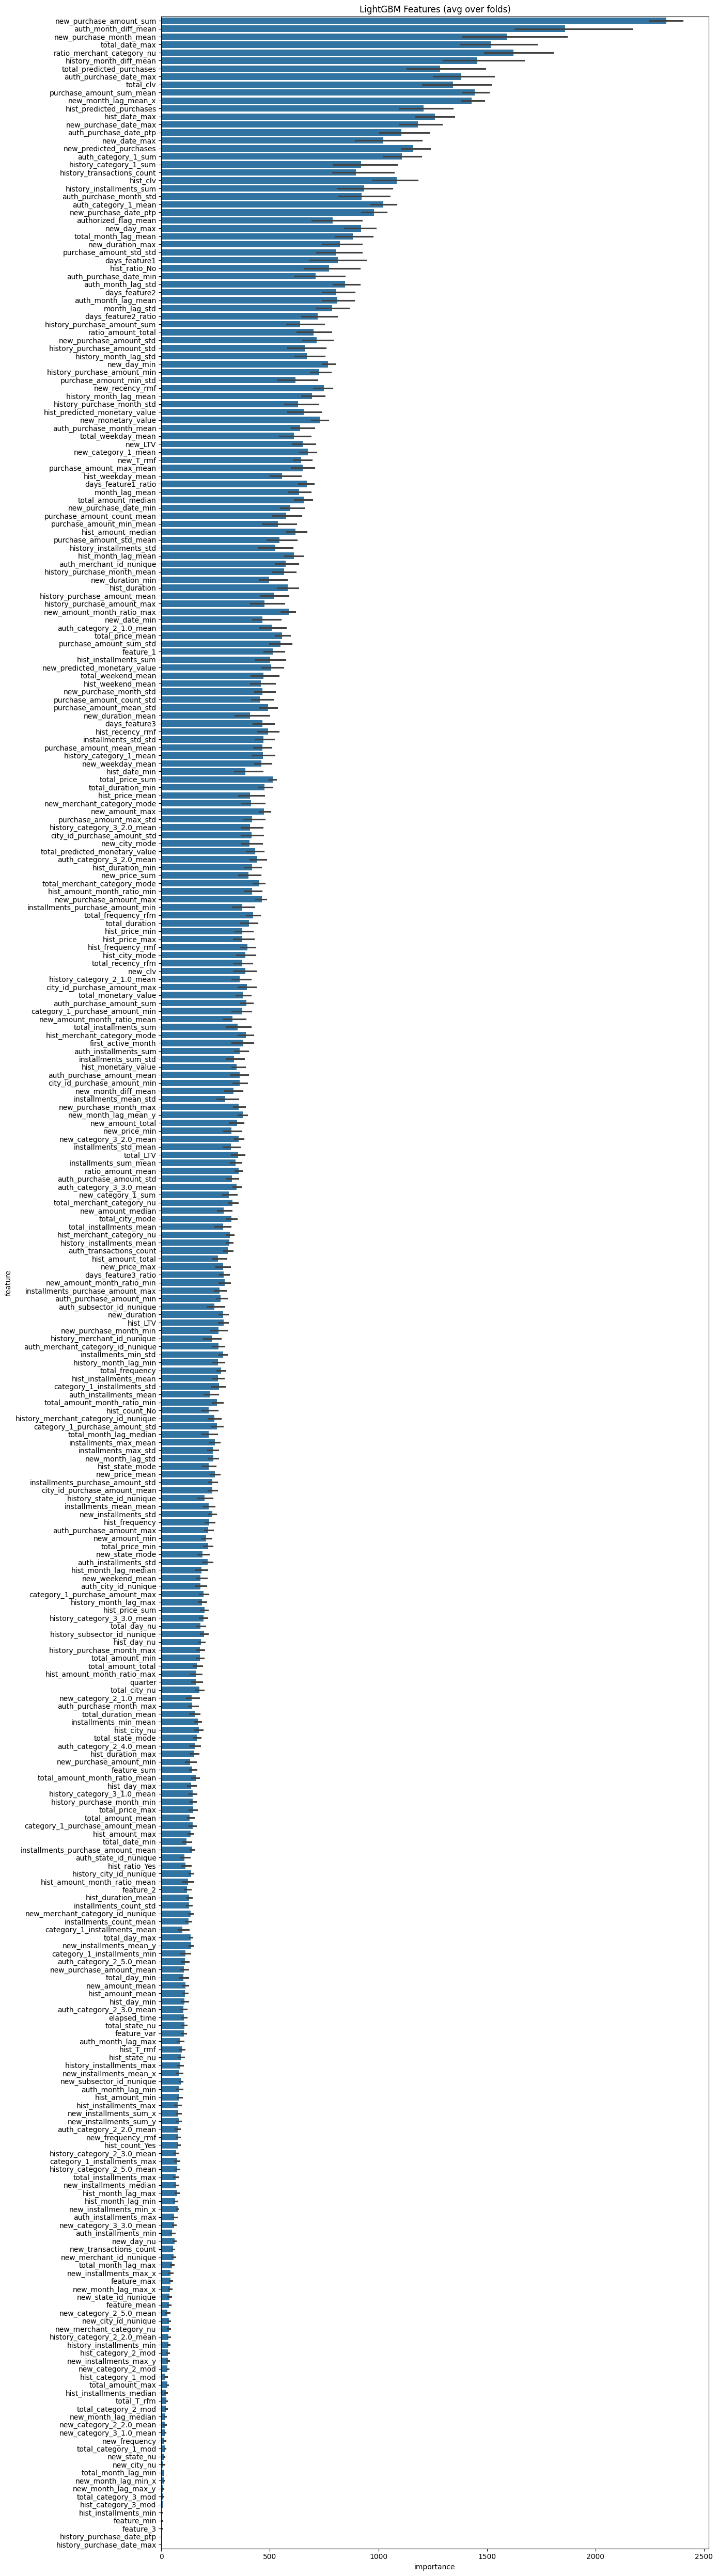

In [12]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')